In [228]:
# import libraries
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

In [229]:
def _steps(x, y):
    int_x = np.round(x)
    ret_x = np.unique(int_x)
    ret_y = []
    for xa in ret_x:
        ret_y.append(np.average(y[int_x == xa]))
    return ret_x, np.array(ret_y)

def plot_scatter(x, returns, normalize=True):
    # seaborn drawing
    import seaborn as sns
    sns.set_style('whitegrid')
    sns.set_palette("Blues_r", 8, 1.0)
    sns.set_context(context='paper', font_scale=1.5, rc={"lines.linewidth": 4})
    
    """
    :param np.ndarray x
    :param np.ndarray returns
    :param bool normalize
    """
    assert(len(x) == len(returns))
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(1, 1, 1)
    gspec = gridspec.GridSpec(3, 3)
    top_histgram = plt.subplot(gspec[0, 1:])
    side_histgram = plt.subplot(gspec[1:, 0])
    main_scatter = plt.subplot(gspec[1:, 1:])
    
    # Normalize
    x = (x - x.mean()) / x.std() if normalize else x
    
    # Plot scatter in Seaborn
    sns.scatterplot(data=pd.DataFrame({'Score': x, 'Return': returns}), x='Score', y='Return', marker='x') # plt.plot(x, returns, 'x')
    main_scatter.xaxis.set_label_position('top')
    main_scatter.yaxis.set_label_position('right')
    main_scatter.set_xlabel('Score', rotation=0, fontsize=16, labelpad=5)
    main_scatter.set_ylabel('Return', rotation=270, fontsize=16, labelpad=15)
    main_scatter.tick_params(labelbottom=True,
                labelleft=False,
                labelright=False,
                labeltop=False)
    
    # Regression line for Information Coefficient
    reg = np.polyfit(x, returns, 1)
    plt.plot(x, np.poly1d(reg)(x), color='#e41a1c', linewidth=3)
    
    # Interval mean plot
    plt.plot(*_steps(x, returns), drawstyle='steps-mid', color='#984ea3', linewidth=3)
    
    # Distribution of x axis at top histgram
    top_histgram.clear()
    top_histgram.hist(x, bins=100)
    top_histgram.xaxis.tick_top()
    
    # Distribution of y axis at side histgram
    side_histgram.clear()
    side_histgram.hist(returns, bins=100, orientation='horizontal', density=True)
    side_histgram.invert_xaxis() # flip the x axis

    # Information coefficient
    ic = np.corrcoef(x, returns)[0, 1]
    plt.title(f'IC={ic:.3f}, y={reg[0]:.3f}x{reg[1]:+.3f}', y=-0.2)
    plt.grid()
    plt.show()

In [230]:
# information coefficient 0.05
mean = np.array([2, 5])
cov = np.array([
    [1, 0.05],
    [0.05, 1]])
x, y = np.random.multivariate_normal(mean, cov, 10000).T

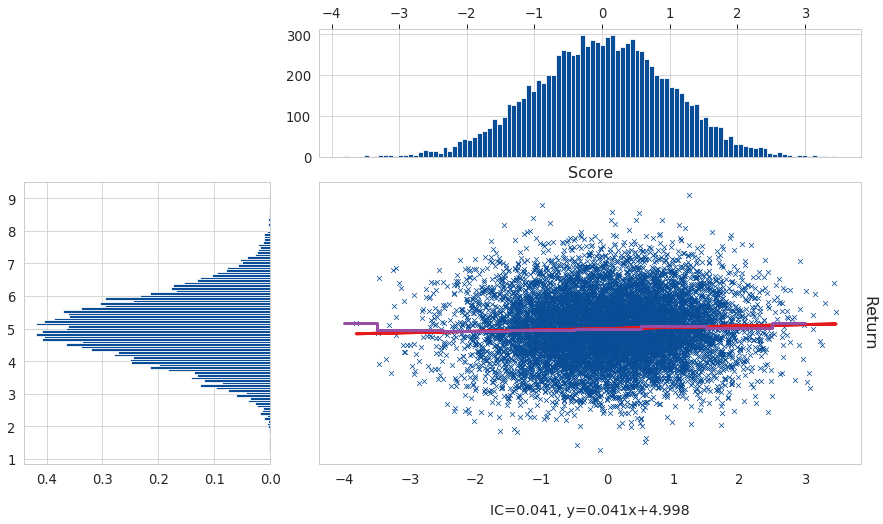

In [231]:
plot_scatter(x, y)

In [232]:
#!/usr/bin/python
import csv
import time
import json
import talib
import requests
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from datetime import datetime, date, timedelta, timezone
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
%matplotlib inline

In [233]:
headers = {'Content-Type': 'application/json'}
api_url_base = 'https://public.bitbank.cc'
pair = 'btc_jpy'
period = '1min'

In [234]:
def bitbank_api(timestamp):
    api_url = '{0}/{1}/candlestick/{2}/{3}'.format(api_url_base, pair, period, timestamp)
    response = requests.get(api_url, headers=headers)

    if response.status_code == 200:
        ohlcv = json.loads(response.content.decode('utf-8'))['data']['candlestick'][0]['ohlcv']
        return ohlcv
    else:
        return None

In [222]:
resdate = '20200504'
response = bitbank_api(resdate)
open, high, low, close, volume, timestamp = [],[],[],[],[],[]
for res in response:
    open.append(int(res[0]))
    high.append(int(res[1]))
    low.append(int(res[2]))
    close.append(int(res[3]))
    volume.append(float(res[4]))
    time_str = str(res[5])
    timestamp.append(datetime.utcfromtimestamp(int(time_str[:10])).strftime('%Y/%m/%d %H:%M:%M')) # naive datetime

date_time_index = pd.to_datetime(timestamp) # convert to DateTimeIndex type
df = pd.DataFrame({'open': open, 'high': high, 'low': low, 'close': close, 'volume': volume}, index=date_time_index)
print(df.shape)
print(df.columns)
df.describe()

(1440, 5)
Index(['open', 'high', 'low', 'close', 'volume'], dtype='object')


,open,high,low,close,volume
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,939277.554167,939542.434722,938988.092361,939270.843750,1.603921
std,10222.716586,10158.235508,10274.691502,10202.362221,2.518705
min,914699.000000,915555.000000,912710.000000,914125.000000,0.000000
25%,930297.000000,930830.500000,930000.000000,930353.750000,0.161800
50%,939384.500000,939619.500000,938992.000000,939341.000000,0.749450
75%,947364.500000,947660.000000,947130.000000,947295.000000,1.948400
max,958269.000000,958269.000000,958236.000000,958269.000000,29.790600


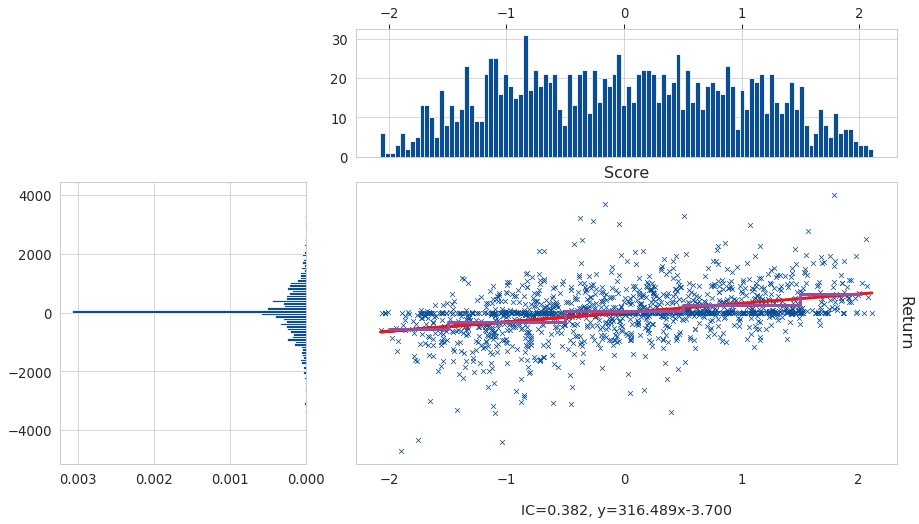

In [224]:
returns = pd.Series(df_['pct'][5:])
ddtrsi = df_['ddt'] + df_['rsi']
indicator = pd.Series(ddtrsi[5:])
returns_numpy = returns.to_numpy(copy=True)
indicator_numpy = indicator.to_numpy(copy=True)
plot_scatter(indicator_numpy, returns)

In [235]:
ddtrsi[5:].describe()

count    1435.000000
mean       47.514687
std       165.752269
min      -296.194968
25%       -89.961576
50%        44.072640
75%       181.645785
max       397.621407
dtype: float64

In [236]:
df['indicator'] = ddtrsi
df.head()

,open,high,low,close,volume,indicator
2020-05-04 00:00:00,953500,954999,953500,954991,1.6889,397.621407
2020-05-04 00:01:01,954997,955286,954997,955286,0.1083,397.621407
2020-05-04 00:02:02,955900,956000,955900,956000,0.2375,397.621407
2020-05-04 00:03:03,956000,956000,956000,956000,0.0540,397.621407
2020-05-04 00:04:04,956000,956000,956000,956000,0.1090,397.621407
